<a href="https://colab.research.google.com/github/hfernandescfc/Bitcasting/blob/main/historical_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


!ls /content/drive/MyDrive/Dissertação/CSvs

Mounted at /content/drive
Binance_ADAUSDT_d.csv	Binance_ETHUSDT_d.csv	 Binance_XRPUSDT_d.csv	  model_outputs_hist.pkl
Binance_AVAXUSDT_d.csv	Binance_MATICUSDT_d.csv  loaded_files.pkl	  model_outputs_tech.pkl
Binance_BTCUSDT_d.csv	Binance_SOLUSDT_d.csv	 model_outputs_block.pkl


In [2]:
'''import pandas as pd
import os
import time
from binance.client import Client
from datetime import timedelta, datetime
import pytz
import numpy as np

epoch = 0
fmt = "%Y-%m-%d %H:%M:%S"  # e.g. 2019-11-16 23:16:15
org_columns = ['open',
               'high', 'low', 'close', 'volume', 'close_time', 'quote_av',
               'trades', 'tb_base_av', 'tb_quote_av', 'ignore']

columns_of_interest = ['open', 'high', 'low', 'close', 'volume']


def init_mod():
    # refer: https://www.binance.com/en/support/articles/360002502072 for API keys
    binance_api_key = "your api key here"
    binance_api_secret = "your api secret here"
    binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)
    global epoch
    epoch = datetime.utcfromtimestamp(0)
    return binance_client


def convert_time_to_utc(pst_time):
    utc = pytz.utc
    pst = pytz.timezone('America/Los_Angeles')
    datetime1 = datetime.strptime(pst_time, fmt)
    pst_time = pst.localize(datetime1)
    return pst_time.astimezone(utc).strftime(fmt)


def convert_time_to_pst(utc_time):
    datetime_obj = datetime.strptime(utc_time, fmt)
    return datetime_obj.replace(tzinfo=time.timezone('UTC')).strftime(fmt)


def to_unixmillis(from_date):
    from_date_obj = datetime.strptime(from_date, fmt)
    past = datetime(1970, 1, 1, tzinfo=from_date_obj.tzinfo)
    return int((from_date_obj - past).total_seconds() * 1000.0)


def to_datetime(ms):
    return datetime.fromtimestamp(int(float(ms) / 1000.0))


def download_data_from_binance(symbol, from_date, to_date, output_filename, step=0, pause=-1, simulate=False):
    """

    :param symbol:
    :param from_date:
    :param to_date:
    :param output_filename:
    :param step: step in number of days. Download data in batches of days given by 'step'
    :param pause: pause seconds before downloading next batch.
        if pause == -1 --> random sleep(2,5)
        if pause == 0 --> no sleep
        if pause == num--> sleep for num of seconds
    :param simulate:
    :return:
    """
    binance_client = init_mod()
    from_date_obj = datetime.strptime(from_date, fmt)
    step_date_obj = from_date_obj + timedelta(days=step)
    step_date = step_date_obj.strftime(fmt)

    from_millis = to_unixmillis(from_date)
    to_millis = to_unixmillis(to_date)
    step_millis = to_unixmillis(step_date)

    count = 0
    while True:
        from_millis_str = str(from_millis)
        step_millis_str = str(step_millis)
        print('Step %d:Downloading data from %s to %s' % (count,
                                                          str(to_datetime(from_millis_str)),
                                                          str(to_datetime(step_millis_str))
                                                          ))
        if not simulate:
            # download data

            klines = binance_client.get_historical_klines(symbol, Client.KLINE_INTERVAL_1HOUR,
                                                          from_millis_str, end_str=step_millis_str)
            klines_len = len(klines)
            if klines_len == 0:
                print('\t Failed to download from %s to %s. Got %d' % (str(to_datetime(from_millis_str)),
                                                                       str(to_datetime(step_millis_str)), klines_len
                                                                       ))
                time.sleep(5)

            print('\t Downloaded data of len %d from %s to %s' % (klines_len,
                                                                  str(to_datetime(from_millis_str)),
                                                                  str(to_datetime(step_millis_str))
                                                                  ))
            new_columns = [item + '_' + symbol for item in org_columns]
            new_columns.insert(0, 'timestamp')

            data_df = pd.DataFrame(klines,
                                   columns=new_columns)
            data_df['timestamp'] = pd.to_datetime(data_df['timestamp'], unit='ms')
            data_df.set_index('timestamp', inplace=True)
            data_df.to_csv(output_filename)

        # move to next step of batches
        from_millis = step_millis
        step_date_obj = step_date_obj + timedelta(days=step)
        step_date = step_date_obj.strftime(fmt)
        step_millis = to_unixmillis(step_date)
        count = count + 1
        if pause == -1:
            pause = np.random.randint(2, 5)
        time.sleep(pause)
        if step_millis >= to_millis:
            break


def concat_binance_data(symbol_list, output_filename):
    df_list = []
    for num, symbol in enumerate(symbol_list):
        filename = str('%s-binance-data.csv' % (symbol))
        df = pd.read_csv(filename, index_col=0)
        df_list.append(df)

    result = pd.concat(df_list, axis=1, sort=True)
    result.index = pd.to_datetime(df.index)
    result = result.sort_index().drop_duplicates(keep='first')
    idx = np.unique(result.index, return_index=True)[1]
    result = result.iloc[idx]

    new_columns = [item + '_' + 'BTCUSDT' for item in columns_of_interest]
    # new_columns.insert(0, 'timestamp')

    for num, symbol in enumerate(symbol_list):
        if symbol == 'BTCUSDT':
            continue
        new_columns.append('close_' + symbol)
        new_columns.append('volume_' + symbol)

    result = result[new_columns]
    result.to_csv(output_filename)


def remove_dup_by_index(output_filename):
    result = pd.read_csv(output_filename, index_col=0)
    result.index = pd.to_datetime(result.index)
    result = result.sort_index()        #.drop_duplicates(keep='first')
    idx = np.unique(result.index, return_index=True)[1]
    result = result.iloc[idx]
    result.to_csv(output_filename)


def append_binance_data(master_output_filename, concat_output_filename):
    master_df = pd.read_csv(master_output_filename)
    new_df = pd.read_csv(concat_output_filename)
    master_df = master_df.append(new_df)
    master_df.set_index('timestamp', inplace=True)
    master_df.index = pd.to_datetime(master_df.index)
    master_df = master_df.sort_index().drop_duplicates(keep='first')
    master_df.to_csv(master_output_filename)


if __name__ == '__main__':
    from_date = '2017-07-01 00:00:00'
    # to_date = time.strftime(fmt, time.localtime())
    # UTC time is 8 hrs ahead of PST
    to_date = '2024-08-29 00:00:00'
    symbol_list = ['BTCUSDT']

    for num, symbol in enumerate(symbol_list):
        output_filename = '%s-binance-data.csv' % (symbol)
        print('-' * 60)
        print('Downloading data from %s to %s for %s' % (from_date, to_date, symbol))
        print('-' * 60)
        download_data_from_binance(symbol, from_date, to_date, output_filename, step=1, pause=-1, simulate=False)

    # concat all currency data
    concat_output_filename = 'binance_crypto_data_final_cleaned.csv'
    concat_binance_data(symbol_list, concat_output_filename)

    # Append the results to master currency data
    master_output_filename = 'crypto_data_master_cleaned.csv'
    append_binance_data(master_output_filename, concat_output_filename)
    remove_dup_by_index(master_output_filename)'''

'import pandas as pd\nimport os\nimport time\nfrom binance.client import Client\nfrom datetime import timedelta, datetime\nimport pytz\nimport numpy as np\n\nepoch = 0\nfmt = "%Y-%m-%d %H:%M:%S"  # e.g. 2019-11-16 23:16:15\norg_columns = [\'open\',\n               \'high\', \'low\', \'close\', \'volume\', \'close_time\', \'quote_av\',\n               \'trades\', \'tb_base_av\', \'tb_quote_av\', \'ignore\']\n\ncolumns_of_interest = [\'open\', \'high\', \'low\', \'close\', \'volume\']\n\n\ndef init_mod():\n    # refer: https://www.binance.com/en/support/articles/360002502072 for API keys\n    binance_api_key = "your api key here"\n    binance_api_secret = "your api secret here"\n    binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)\n    global epoch\n    epoch = datetime.utcfromtimestamp(0)\n    return binance_client\n\n\ndef convert_time_to_utc(pst_time):\n    utc = pytz.utc\n    pst = pytz.timezone(\'America/Los_Angeles\')\n    datetime1 = datetime.strptim

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os

# Path to the directory containing the CSV files
csv_dir = '/content/drive/MyDrive/Dissertação/CSvs'

# Get a list of all CSV files in the directory
csv_files = [f for f in os.listdir(csv_dir) if f.endswith('.csv')]

# Create a dictionary to store the dataframes
dataframes = {}

# Loop through each CSV file and create a dataframe
for file in csv_files:
    # Get the file name without the extension
    name = os.path.splitext(file)[0]

    # Read the CSV file into a dataframe
    df = pd.read_csv(os.path.join(csv_dir, file), header=1)

    # Store the dataframe in the dictionary using the file name as the key
    dataframes[name] = df

# Now you can access each dataframe using the file name
# For example: dataframes['ada'], dataframes['avax'], etc.

# Print the names of the created dataframes
print("Created dataframes:")
for name in dataframes.keys():
    print(f"- {name}")

# Optional: If you want to create separate variables for each dataframe
for name, df in dataframes.items():
    globals()[name] = df

# Now you can access the dataframes directly by their names
# For example: ada, avax, eth, matic_eth, sol

Created dataframes:
- Binance_BTCUSDT_d
- Binance_ETHUSDT_d
- Binance_AVAXUSDT_d
- Binance_SOLUSDT_d
- Binance_ADAUSDT_d
- Binance_XRPUSDT_d
- Binance_MATICUSDT_d


In [4]:
Binance_BTCUSDT_d = Binance_BTCUSDT_d.iloc[:, 1:].drop(columns = 'Symbol').sort_values(by='Date').set_index('Date')
Binance_BTCUSDT_d['Close_t+1'] = Binance_BTCUSDT_d['Close'].shift(-1)
Binance_BTCUSDT_d['Close_Diff'] = Binance_BTCUSDT_d['Close'].diff()
Binance_BTCUSDT_d['Direction_t+1'] = np.where(Binance_BTCUSDT_d['Close_t+1'] > Binance_BTCUSDT_d['Close'], 1, 0)

In [5]:
Binance_BTCUSDT_d.head()

,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount,Close_t+1,Close_Diff,Direction_t+1
Date,,,,,,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,3.454770e+06,3427,4108.37,NaN,0
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,5.086958e+06,5233,4139.98,-176.71,1
2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763,1.549484e+06,2153,4086.29,31.61,0
2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022,1.930364e+06,2321,4016.00,-53.69,0
2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060,2.797232e+06,3972,4040.00,-70.29,1


In [6]:
Binance_BTCUSDT_d['Direction_t+1'].value_counts()

,count
Direction_t+1,
1,1233
0,1160


In [7]:
''' from matplotlib.gridspec import GridSpec

def plot_feature_transformations(df, feature):
    fig = plt.figure(figsize=(15, 12))
    gs = GridSpec(3, 1, figure=fig)

    # Original feature
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(df.index, df[feature])
    ax1.set_title(f'Original {feature}')
    ax1.set_xlabel('Date')
    ax1.set_ylabel(feature)

    # Differenced feature
    ax2 = fig.add_subplot(gs[1, 0])
    differenced = df[feature].diff()
    ax2.plot(df.index, differenced)
    ax2.set_title(f'Differenced {feature}')
    ax2.set_xlabel('Date')
    ax2.set_ylabel(f'Diff {feature}')

    # Log-differenced feature
    ax3 = fig.add_subplot(gs[2, 0])
    log_differenced = np.log(df[feature]).diff()
    ax3.plot(df.index, log_differenced)
    ax3.set_title(f'Log-Differenced {feature}')
    ax3.set_xlabel('Date')
    ax3.set_ylabel(f'Log-Diff {feature}')

    plt.tight_layout()
    plt.show()

# Assuming your dataframe is named Binance_BTCUSDT_d
features = ['Open', 'High', 'Low', 'Close', 'Volume BTC', 'Volume USDT', 'tradecount']

for feature in features:
    plot_feature_transformations(Binance_BTCUSDT_d, feature) '''

" from matplotlib.gridspec import GridSpec\n\ndef plot_feature_transformations(df, feature):\n    fig = plt.figure(figsize=(15, 12))\n    gs = GridSpec(3, 1, figure=fig)\n\n    # Original feature\n    ax1 = fig.add_subplot(gs[0, 0])\n    ax1.plot(df.index, df[feature])\n    ax1.set_title(f'Original {feature}')\n    ax1.set_xlabel('Date')\n    ax1.set_ylabel(feature)\n\n    # Differenced feature\n    ax2 = fig.add_subplot(gs[1, 0])\n    differenced = df[feature].diff()\n    ax2.plot(df.index, differenced)\n    ax2.set_title(f'Differenced {feature}')\n    ax2.set_xlabel('Date')\n    ax2.set_ylabel(f'Diff {feature}')\n\n    # Log-differenced feature\n    ax3 = fig.add_subplot(gs[2, 0])\n    log_differenced = np.log(df[feature]).diff()\n    ax3.plot(df.index, log_differenced)\n    ax3.set_title(f'Log-Differenced {feature}')\n    ax3.set_xlabel('Date')\n    ax3.set_ylabel(f'Log-Diff {feature}')\n\n    plt.tight_layout()\n    plt.show()\n\n# Assuming your dataframe is named Binance_BTCUSDT_d

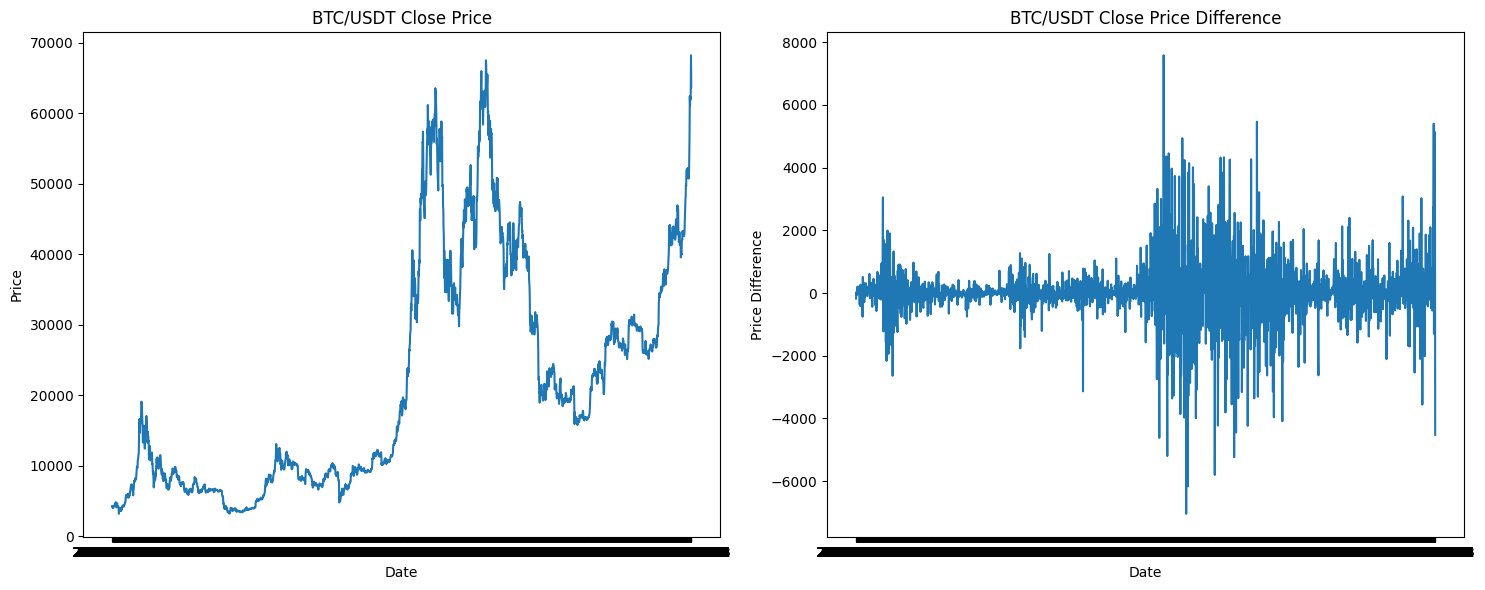

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 'Close' on the first subplot
ax1.plot(Binance_BTCUSDT_d.index, Binance_BTCUSDT_d['Close'])
ax1.set_title('BTC/USDT Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')

# Plot 'Close_Diff' on the second subplot
ax2.plot(Binance_BTCUSDT_d.index, Binance_BTCUSDT_d['Close_Diff'])
ax2.set_title('BTC/USDT Close Price Difference')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price Difference')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [9]:
features = ['Open', 'High', 'Low', 'Close', 'Volume BTC', 'Volume USDT', 'tradecount']

def log_diff_transform(series):
    # Add a small constant to avoid log(0)
    return np.log(series + 1).diff()

# Create a new dataframe with log-differenced features
Binance_BTCUSDT_d_transformed = pd.DataFrame(index=Binance_BTCUSDT_d.index)

for feature in features:
    new_column_name = f'log_diff_{feature.lower().replace(" ", "_")}'
    Binance_BTCUSDT_d_transformed[new_column_name] = log_diff_transform(Binance_BTCUSDT_d[feature])

# Remove the first row which will contain NaN values due to differencing
Binance_BTCUSDT_d_transformed = Binance_BTCUSDT_d_transformed.dropna()

# Display the first few rows of the transformed dataframe
print(Binance_BTCUSDT_d_transformed.head())

# Display summary statistics
print(Binance_BTCUSDT_d_transformed.describe())

# Check for any remaining NaN values
print("\nNumber of NaN values in each column:")
print(Binance_BTCUSDT_d_transformed.isna().sum())

            log_diff_open  log_diff_high  log_diff_low  log_diff_close  \
Date                                                                     
2017-08-18       0.005521      -0.025709     -0.064376       -0.042103   
2017-08-19      -0.042103      -0.043668     -0.022789        0.007663   
2017-08-20       0.003064       0.006285      0.046331       -0.013050   
2017-08-21      -0.012659      -0.021953     -0.030414       -0.017347   
2017-08-22      -0.013140      -0.003598     -0.140181        0.005957   

            log_diff_volume_btc  log_diff_volume_usdt  log_diff_tradecount  
Date                                                                        
2017-08-18             0.411029              0.386924             0.423199  
2017-08-19            -1.144586             -1.188758            -0.887849  
2017-08-20             0.202414              0.219787             0.075102  
2017-08-21             0.392013              0.370921             0.537093  
2017-08-22         

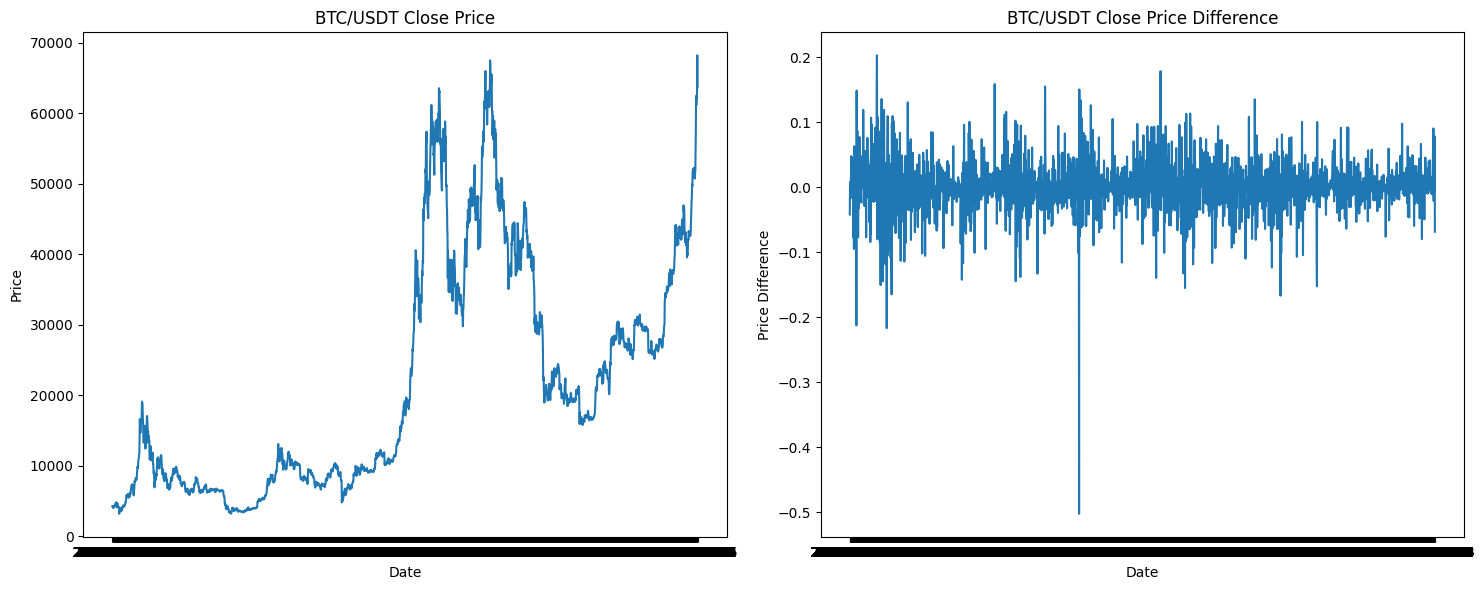

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 'Close' on the first subplot
ax1.plot(Binance_BTCUSDT_d.index, Binance_BTCUSDT_d['Close'])
ax1.set_title('BTC/USDT Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')

# Plot 'Close_Diff' on the second subplot
ax2.plot(Binance_BTCUSDT_d_transformed.index, Binance_BTCUSDT_d_transformed['log_diff_close'])
ax2.set_title('BTC/USDT Close Price Difference')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price Difference')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [11]:
Binance_BTCUSDT_d_transformed.columns

Index(['log_diff_open', 'log_diff_high', 'log_diff_low', 'log_diff_close',
       'log_diff_volume_btc', 'log_diff_volume_usdt', 'log_diff_tradecount'],
      dtype='object')

In [12]:
Binance_BTCUSDT_d_transformed['Close_t+1'] = Binance_BTCUSDT_d_transformed['log_diff_close'].shift(-1)

Binance_BTCUSDT_d_transformed['Direction_t+1'] = np.where(Binance_BTCUSDT_d_transformed['Close_t+1'] > 0, 1, 0)

Binance_BTCUSDT_d_transformed.dropna(inplace=True)

In [13]:
Binance_BTCUSDT_d_transformed.iloc[12:20,:]

,log_diff_open,log_diff_high,log_diff_low,log_diff_close,log_diff_volume_btc,log_diff_volume_usdt,log_diff_tradecount,Close_t+1,Direction_t+1
Date,,,,,,,,,
2017-08-30,0.047288,0.004670,0.023470,-0.007073,0.291902,0.317178,0.288643,0.036580,1
2017-08-31,-0.002057,0.020844,0.031013,0.036580,-0.372097,-0.356179,-0.288162,0.023013,1
2017-09-01,0.029147,0.029096,0.021655,0.023013,0.006626,0.032524,-0.039451,-0.077979,0
2017-09-02,0.022402,0.010917,-0.082341,-0.077979,0.504436,0.468468,0.625154,0.008224,1
2017-09-03,-0.061838,-0.046494,0.002669,0.008224,-0.295446,-0.310564,-0.216112,-0.095057,0
2017-09-04,-0.000776,-0.040522,-0.078809,-0.095057,0.701213,0.638466,0.436363,0.062926,1
2017-09-05,-0.092481,-0.009429,-0.097605,0.062926,-0.126393,-0.150646,0.079101,0.056377,1
2017-09-06,0.061259,0.038886,0.184968,0.056377,-0.419707,-0.337765,-0.236997,0.015428,1


### RUN XGBOOST without adding windows

Accuracy: 0.4969
Precision: 0.5039
Recall: 0.5309
F1 Score: 0.5170


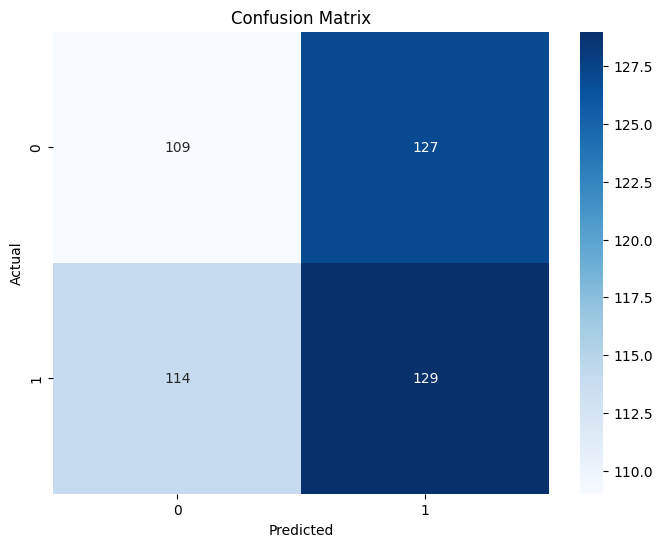

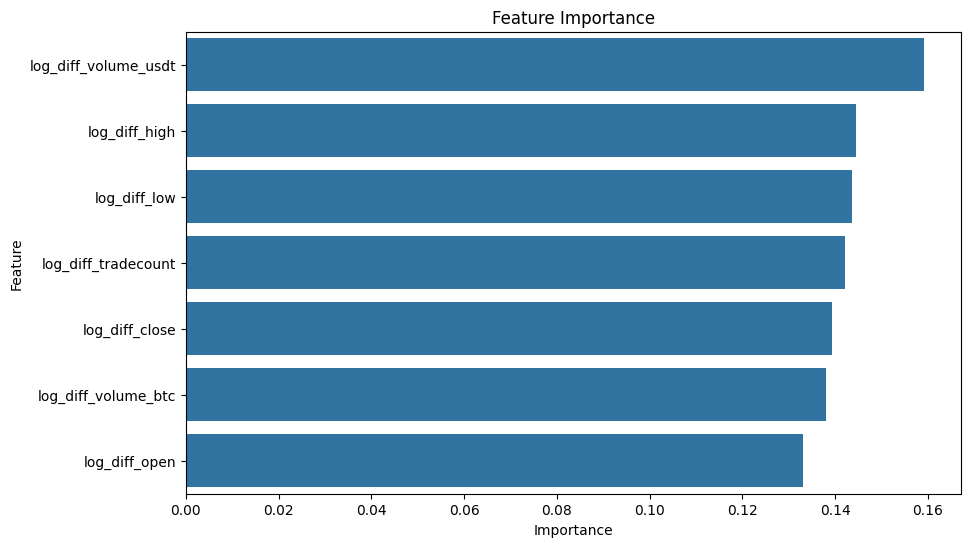

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns


# Drop the last row as it will have NaN in the target column
Binance_BTCUSDT_d_transformed = Binance_BTCUSDT_d_transformed.dropna()

# Prepare features and target
X = Binance_BTCUSDT_d_transformed.drop(['Direction_t+1', 'Close_t+1'], axis=1)
y = Binance_BTCUSDT_d_transformed['Direction_t+1']

# Split the data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Initialize and train the XGBoost classifier
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Create and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature importance
feature_importance = model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Adding windows non transformed DF

<ipython-input-15-fb635e26aaee>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
<ipython-input-15-fb635e26aaee>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
<ipython-input-15-fb635e26aaee>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

Best number of lags: 4
Best accuracy: 0.5432


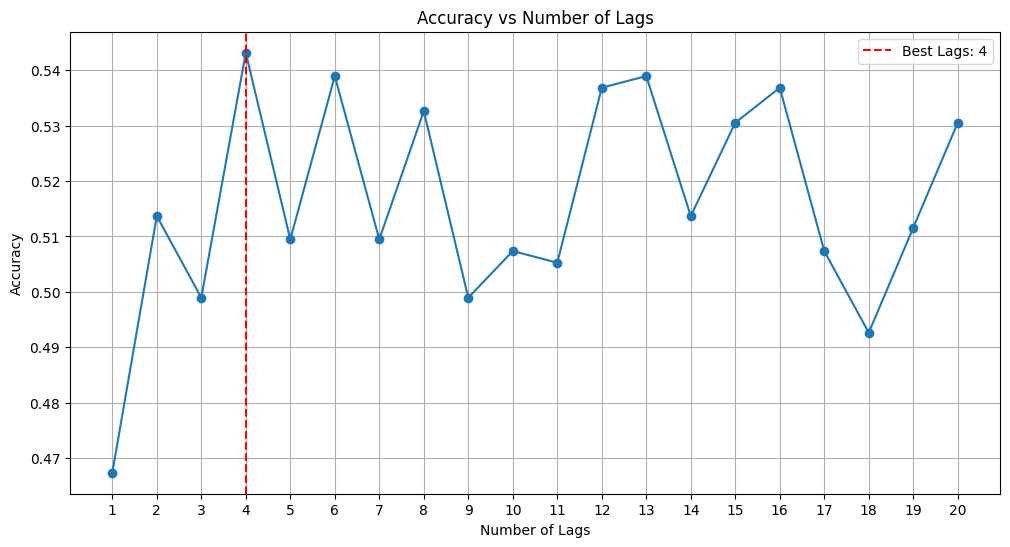

Final model accuracy: 0.5474


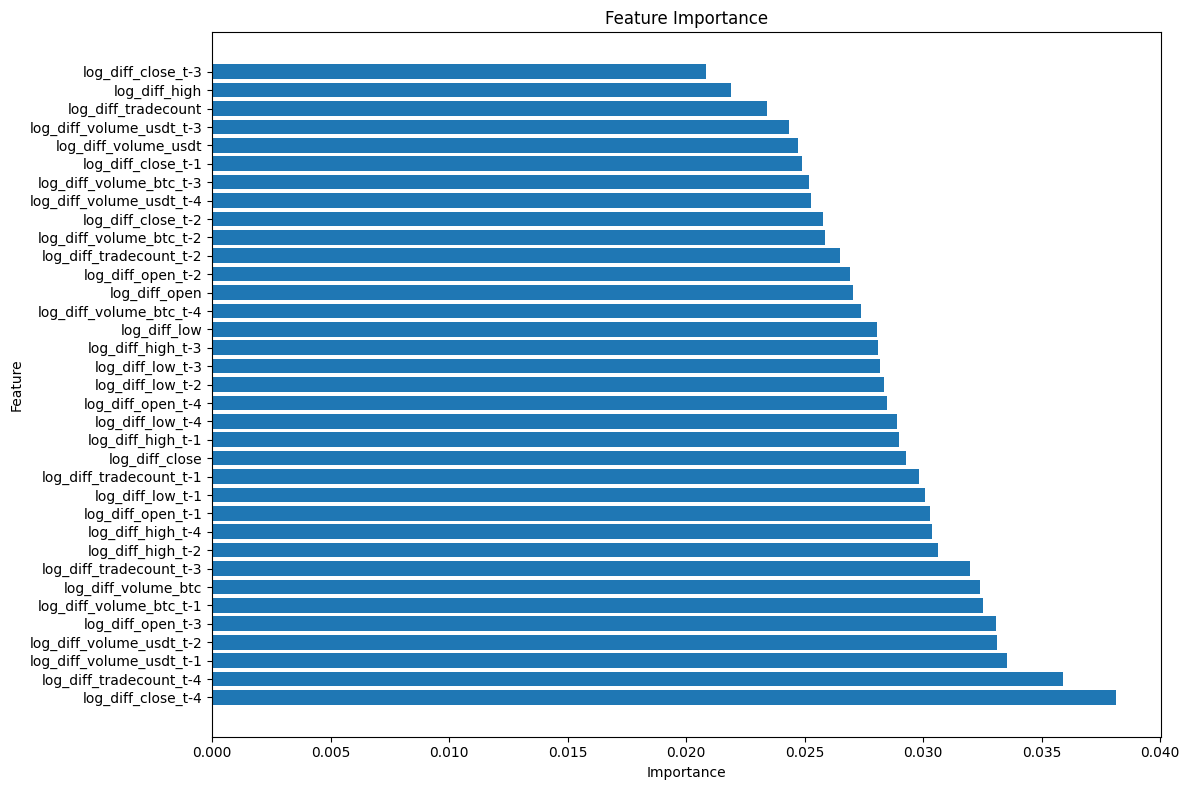

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

def create_lagged_features(df, col_names, max_lags):
    df_copy = df.copy()
    for col_name in col_names:
        for i in range(1, max_lags + 1):
            df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
    return df_copy

def prepare_data(df, feature_cols, max_lags):
    df_prepared = create_lagged_features(df, feature_cols, max_lags)
    df_prepared = df_prepared.dropna()  # Remove rows with NaN values
    return df_prepared

def split_data(df, test_size=0.2):
    train = df.iloc[:int(len(df) * (1 - test_size))]
    test = df.iloc[int(len(df) * (1 - test_size)):]
    return train, test

def tune_lags(train_data, test_data, feature_cols, max_lags):
    accuracies = []

    for lags in range(1, max_lags + 1):
        features = [f'{col}_t-{i}' for col in feature_cols for i in range(1, lags + 1)]

        X_train = pd.concat([train_data[features], train_data[feature_cols]], axis = 1)
        y_train = train_data['Direction_t+1']
        X_test = pd.concat([test_data[features], test_data[feature_cols]], axis = 1)
        y_test = test_data['Direction_t+1']

        model = XGBClassifier(eval_metric='logloss', random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    best_lags = np.argmax(accuracies) + 1
    best_accuracy = np.max(accuracies)

    return best_lags, best_accuracy, accuracies

# Main execution
max_lags = 20  # You can adjust this value
feature_cols = ['log_diff_open', 'log_diff_high', 'log_diff_low', 'log_diff_close', 'log_diff_volume_btc', 'log_diff_volume_usdt', 'log_diff_tradecount']

# Prepare the data
df_prepared = prepare_data(Binance_BTCUSDT_d_transformed, feature_cols, max_lags)

# Create target variable
df_prepared['Direction_t+1'] = np.where(df_prepared['Close_t+1'] > 0, 1, 0)
df_prepared = df_prepared.dropna()

# Split the data
train_data, test_data = split_data(df_prepared)

# Tune the number of lags
best_lags, best_accuracy, accuracies = tune_lags(train_data, test_data, feature_cols, max_lags)

print(f"Best number of lags: {best_lags}")
print(f"Best accuracy: {best_accuracy:.4f}")

# Plot accuracies
plt.figure(figsize=(12, 6))
plt.plot(range(1, max_lags + 1), accuracies, marker='o')
plt.title('Accuracy vs Number of Lags')
plt.xlabel('Number of Lags')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(range(1, max_lags + 1))
plt.axvline(x=best_lags, color='r', linestyle='--', label=f'Best Lags: {best_lags}')
plt.legend()
plt.show()

# Train final model with best number of lags
features = [f'{col}_t-{i}' for col in feature_cols for i in range(1, best_lags + 1)]

all_features = feature_cols + features

X_train = train_data[all_features]
y_train = train_data['Direction_t+1']
X_test = test_data[all_features]
y_test = test_data['Direction_t+1']

final_model = XGBClassifier(eval_metric='logloss', random_state=42)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)

print(f"Final model accuracy: {final_accuracy:.4f}")

# Feature importance
feature_importance = final_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': all_features, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
<ipython-input-16-c9be1d9f9b5f>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
<ipython-input-16-c9be1d9f9b5f>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.cop

[LightGBM] [Info] Number of positive: 969, number of negative: 903
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517628 -> initscore=0.070542
[LightGBM] [Info] Start training from score 0.070542
[LightGBM] [Info] Number of positive: 969, number of negative: 903
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517628 -> initscore=0.070542
[LightGBM] [Info] Start training from score 0.070542
[LightGBM] [Info] Number o

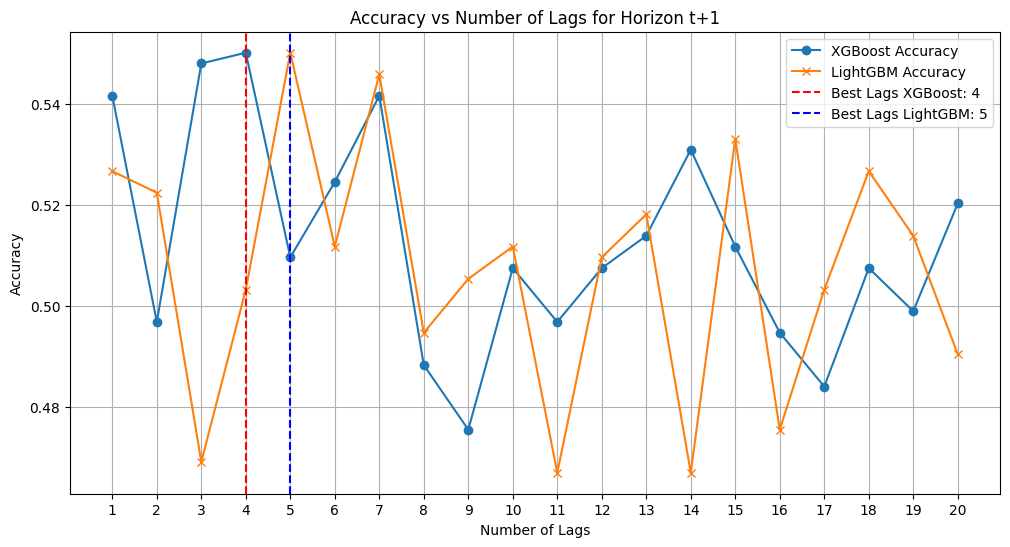

Horizon t+1: XGBoost - Best Lags = 4, Best Accuracy = 0.5501
Horizon t+1: LightGBM - Best Lags = 5, Best Accuracy = 0.5501


<ipython-input-16-c9be1d9f9b5f>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
<ipython-input-16-c9be1d9f9b5f>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
<ipython-input-16-c9be1d9f9b5f>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

[LightGBM] [Info] Number of positive: 970, number of negative: 902
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.518162 -> initscore=0.072682
[LightGBM] [Info] Start training from score 0.072682
[LightGBM] [Info] Number of positive: 970, number of negative: 902
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.518162 -> initscore=0.072682
[LightGBM] [Inf

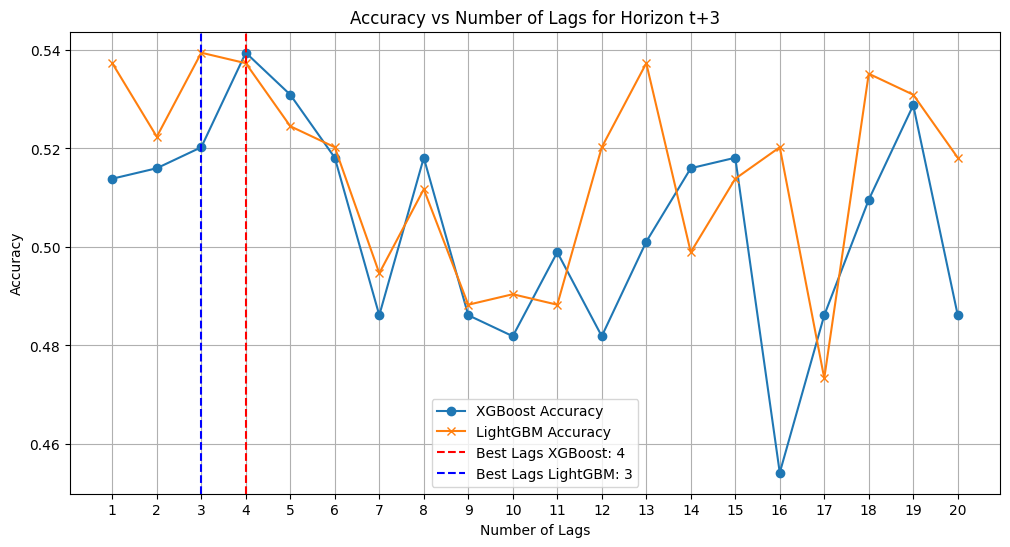

Horizon t+3: XGBoost - Best Lags = 4, Best Accuracy = 0.5394
Horizon t+3: LightGBM - Best Lags = 3, Best Accuracy = 0.5394


<ipython-input-16-c9be1d9f9b5f>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
<ipython-input-16-c9be1d9f9b5f>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
<ipython-input-16-c9be1d9f9b5f>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

[LightGBM] [Info] Number of positive: 972, number of negative: 900
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519231 -> initscore=0.076961
[LightGBM] [Info] Start training from score 0.076961
[LightGBM] [Info] Number of positive: 972, number of negative: 900
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519231 -> initscore=0.076961
[LightGBM] [Info] Start training from score 0.076961
[LightGBM] [Info] Number o

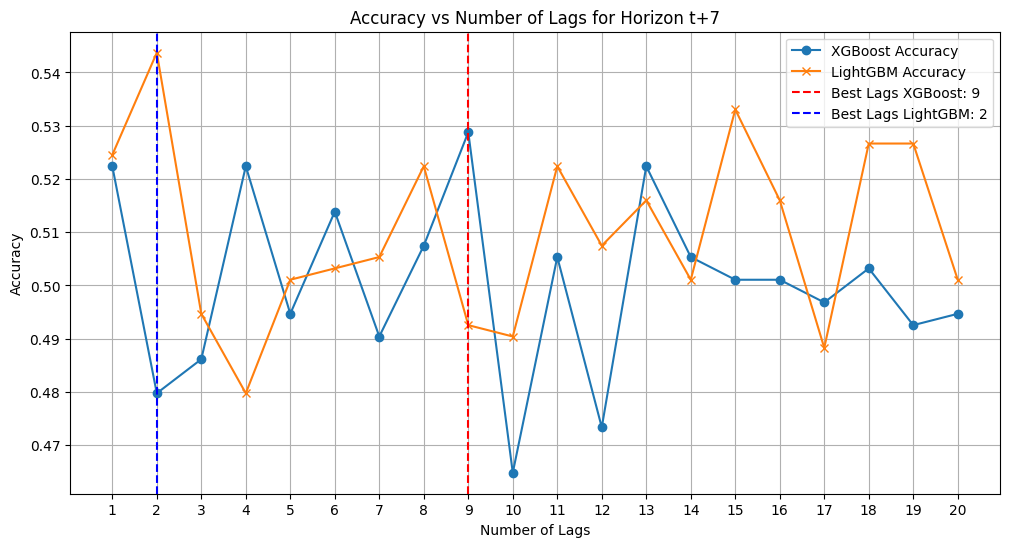

Horizon t+7: XGBoost - Best Lags = 9, Best Accuracy = 0.5288
Horizon t+7: LightGBM - Best Lags = 2, Best Accuracy = 0.5437


<ipython-input-16-c9be1d9f9b5f>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
<ipython-input-16-c9be1d9f9b5f>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
<ipython-input-16-c9be1d9f9b5f>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

[LightGBM] [Info] Number of positive: 972, number of negative: 900
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519231 -> initscore=0.076961
[LightGBM] [Info] Start training from score 0.076961
[LightGBM] [Info] Number of positive: 972, number of negative: 900
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519231 -> initscore=0.076961
[LightGBM] [Info] Start training from score 0.076961
[LightGBM] [Info] Number o

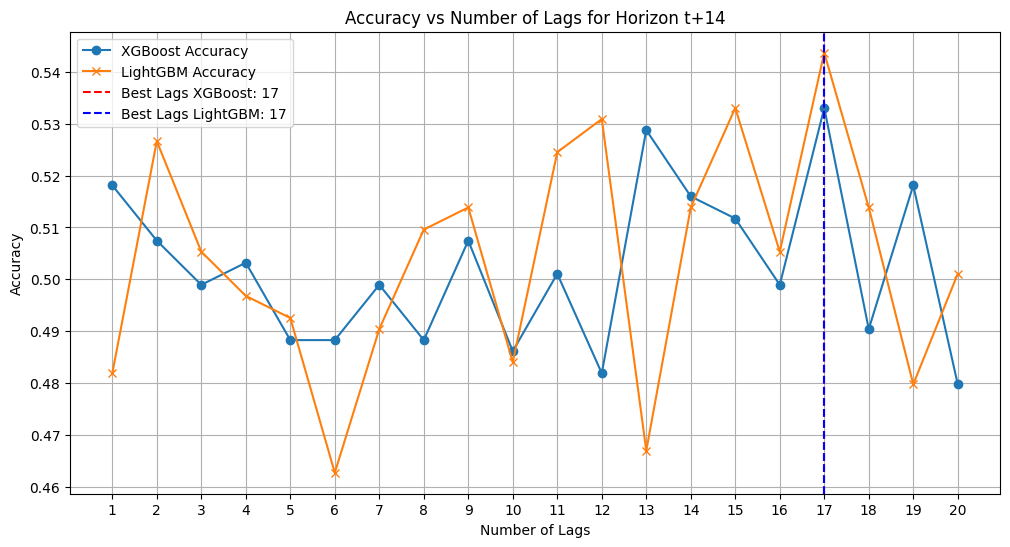

Horizon t+14: XGBoost - Best Lags = 17, Best Accuracy = 0.5330
Horizon t+14: LightGBM - Best Lags = 17, Best Accuracy = 0.5437


<ipython-input-16-c9be1d9f9b5f>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
<ipython-input-16-c9be1d9f9b5f>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
<ipython-input-16-c9be1d9f9b5f>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

[LightGBM] [Info] Number of positive: 970, number of negative: 902
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.518162 -> initscore=0.072682
[LightGBM] [Info] Start training from score 0.072682
[LightGBM] [Info] Number of positive: 970, number of negative: 902
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.518162 -> initscore=0.072682
[LightGBM] [Info] Start training from score 0.072682
[LightGBM] [Info] Number o

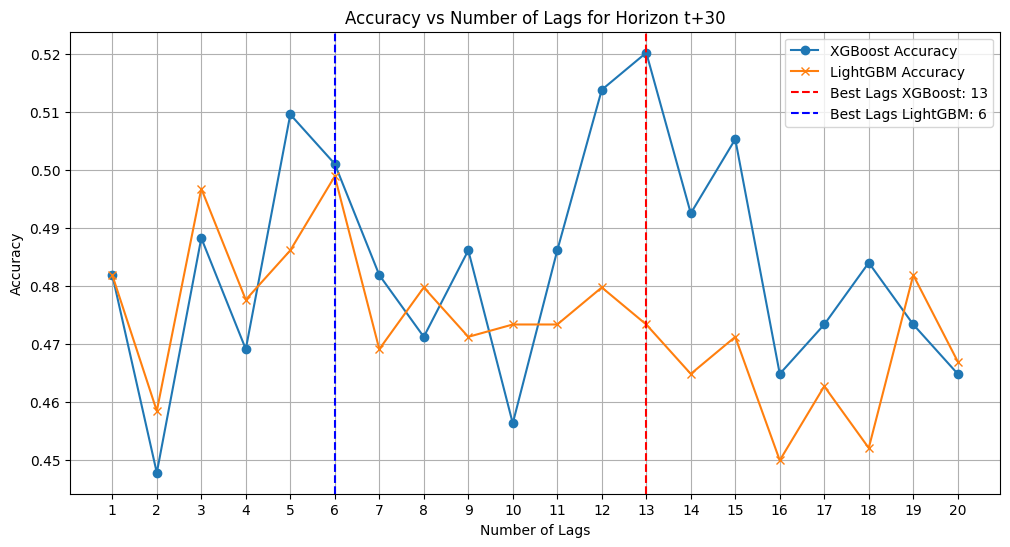

Horizon t+30: XGBoost - Best Lags = 13, Best Accuracy = 0.5203
Horizon t+30: LightGBM - Best Lags = 6, Best Accuracy = 0.4989
Best lags and accuracies for each horizon with both models:
Horizon t+1:
  XGBoost - Best Lags = 4, Best Accuracy = 0.5501
  LightGBM - Best Lags = 5, Best Accuracy = 0.5501
Horizon t+3:
  XGBoost - Best Lags = 4, Best Accuracy = 0.5394
  LightGBM - Best Lags = 3, Best Accuracy = 0.5394
Horizon t+7:
  XGBoost - Best Lags = 9, Best Accuracy = 0.5288
  LightGBM - Best Lags = 2, Best Accuracy = 0.5437
Horizon t+14:
  XGBoost - Best Lags = 17, Best Accuracy = 0.5330
  LightGBM - Best Lags = 17, Best Accuracy = 0.5437
Horizon t+30:
  XGBoost - Best Lags = 13, Best Accuracy = 0.5203
  LightGBM - Best Lags = 6, Best Accuracy = 0.4989


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
import warnings
import matplotlib.pyplot as plt
import pickle

warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

# Define target horizons
target_horizons = [1, 3, 7, 14, 30]


# Create target columns for each horizon
for horizon in target_horizons:
    Binance_BTCUSDT_d_transformed[f'Close_t+{horizon}'] = Binance_BTCUSDT_d_transformed['log_diff_close'].shift(-horizon)
    Binance_BTCUSDT_d_transformed[f'Direction_t+{horizon}'] = np.where(Binance_BTCUSDT_d_transformed[f'Close_t+{horizon}'] > 0, 1, 0)

def create_lagged_features(df, col_names, max_lags):
    df_copy = df.copy()
    for col_name in col_names:
        for i in range(1, max_lags + 1):
            df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
    return df_copy

def prepare_data(df, feature_cols, max_lags, target_column):
    df_prepared = create_lagged_features(df, feature_cols, max_lags)
    df_prepared = df_prepared.dropna()  # Remove rows with NaN values
    return df_prepared

def split_data(df, test_size=0.2):
    train = df.iloc[:int(len(df) * (1 - test_size))]
    test = df.iloc[int(len(df) * (1 - test_size)):]
    return train, test

def tune_lags(train_data, test_data, feature_cols, target_column, max_lags, model_type="xgboost"):
    accuracies = []

    for lags in range(1, max_lags + 1):
        features = [f'{col}_t-{i}' for col in feature_cols for i in range(1, lags + 1)]

        X_train = pd.concat([train_data[features], train_data[feature_cols]], axis=1)
        y_train = train_data[target_column]
        X_test = pd.concat([test_data[features], test_data[feature_cols]], axis=1)
        y_test = test_data[target_column]

        # Choose model based on model_type parameter
        if model_type == "xgboost":
            model = XGBClassifier(eval_metric='logloss', random_state=42)
        elif model_type == "lightgbm":
            model = LGBMClassifier(random_state=42)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    best_lags = np.argmax(accuracies) + 1
    best_accuracy = np.max(accuracies)

    return best_lags, best_accuracy, accuracies

# Main execution
max_lags = 20  # You can adjust this value
feature_cols = ['log_diff_open', 'log_diff_high', 'log_diff_low', 'log_diff_close', 'log_diff_volume_btc', 'log_diff_volume_usdt', 'log_diff_tradecount']

# Dictionary to store results for each horizon
results_by_horizon = {}

for horizon in target_horizons:
    target_column = f'Direction_t+{horizon}'

    # Prepare the data
    df_prepared = prepare_data(Binance_BTCUSDT_d_transformed, feature_cols, max_lags, target_column)
    df_prepared = df_prepared.dropna()

    # Split the data
    train_data, test_data = split_data(df_prepared)

    # Tune the number of lags for XGBoost
    best_lags_xgb, best_accuracy_xgb, accuracies_xgb = tune_lags(train_data, test_data, feature_cols, target_column, max_lags, model_type="xgboost")

    # Tune the number of lags for LightGBM
    best_lags_lgbm, best_accuracy_lgbm, accuracies_lgbm = tune_lags(train_data, test_data, feature_cols, target_column, max_lags, model_type="lightgbm")

    # Store the best results for the horizon
    results_by_horizon[horizon] = {
        "XGBoost": {"best_lags": best_lags_xgb, "best_accuracy": best_accuracy_xgb},
        "LightGBM": {"best_lags": best_lags_lgbm, "best_accuracy": best_accuracy_lgbm}
    }

    # Plot accuracies for each model
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, max_lags + 1), accuracies_xgb, marker='o', label='XGBoost Accuracy')
    plt.plot(range(1, max_lags + 1), accuracies_lgbm, marker='x', label='LightGBM Accuracy')
    plt.title(f'Accuracy vs Number of Lags for Horizon t+{horizon}')
    plt.xlabel('Number of Lags')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.xticks(range(1, max_lags + 1))
    plt.axvline(x=best_lags_xgb, color='red', linestyle='--', label=f'Best Lags XGBoost: {best_lags_xgb}')
    plt.axvline(x=best_lags_lgbm, color='blue', linestyle='--', label=f'Best Lags LightGBM: {best_lags_lgbm}')
    plt.legend()
    plt.show()

    print(f"Horizon t+{horizon}: XGBoost - Best Lags = {best_lags_xgb}, Best Accuracy = {best_accuracy_xgb:.4f}")
    print(f"Horizon t+{horizon}: LightGBM - Best Lags = {best_lags_lgbm}, Best Accuracy = {best_accuracy_lgbm:.4f}")

# Summarize best results across horizons
print("Best lags and accuracies for each horizon with both models:")
for horizon in target_horizons:
    print(f"Horizon t+{horizon}:")
    print(f"  XGBoost - Best Lags = {results_by_horizon[horizon]['XGBoost']['best_lags']}, Best Accuracy = {results_by_horizon[horizon]['XGBoost']['best_accuracy']:.4f}")
    print(f"  LightGBM - Best Lags = {results_by_horizon[horizon]['LightGBM']['best_lags']}, Best Accuracy = {results_by_horizon[horizon]['LightGBM']['best_accuracy']:.4f}")


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import warnings
import matplotlib.pyplot as plt
import pickle

warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

# Define target horizons
target_horizons = [1, 3, 7, 14, 30]

# Determine o maior horizonte
max_horizonte = max(target_horizons)

# Remova as últimas linhas do dataframe para garantir o mesmo período
btc_df_common = Binance_BTCUSDT_d_transformed.iloc[:-max_horizonte]
btc_df_common = btc_df_common[(btc_df_common.index >= '2017-11-21') & (btc_df_common.index <= '2024-01-04')]


# Create target columns for each horizon
for horizon in target_horizons:
    btc_df_common[f'Close_t+{horizon}'] = btc_df_common['log_diff_close'].shift(-horizon)
    btc_df_common[f'Direction_t+{horizon}'] = np.where(btc_df_common[f'Close_t+{horizon}'] > 0, 1, 0)


def create_lagged_features(df, col_names, max_lags):
    df_copy = df.copy()
    for col_name in col_names:
        for i in range(1, max_lags + 1):
            df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
    return df_copy

def prepare_data(df, feature_cols, max_lags, target_column):
    df_prepared = create_lagged_features(df, feature_cols, max_lags)
    df_prepared = df_prepared.dropna()  # Remove rows with NaN values
    return df_prepared

def split_data(df, test_size=0.2):
    train = df.iloc[:int(len(df) * (1 - test_size))]
    test = df.iloc[int(len(df) * (1 - test_size)):]
    return train, test

# Refatoração do código
def tune_lags_with_cv(data, feature_cols, target_column, max_lags, n_splits=5, model_type='xgboost'):
    """
    Ajuste do número de lags usando validação cruzada com TimeSeriesSplit.
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    accuracies = []
    best_outputs = None
    best_probabilities = None

    for lags in range(1, max_lags + 1):
        features = [f'{col}_t-{i}' for col in feature_cols for i in range(1, lags + 1)]
        features += feature_cols  # Incluir as features sem lag para complementar

        fold_accuracies = []

        for train_idx, test_idx in tscv.split(data):
            train_data = data.iloc[train_idx]
            test_data = data.iloc[test_idx]

            X_train = train_data[features]
            y_train = train_data[target_column]
            X_test = test_data[features]
            y_test = test_data[target_column]

            # Escolher modelo com base no parâmetro model_type
            if model_type == "xgboost":
                model = XGBClassifier(eval_metric='logloss', random_state=42)
            elif model_type == "lightgbm":
                model = LGBMClassifier(random_state=42)

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1]

            accuracy = accuracy_score(y_test, y_pred)
            fold_accuracies.append(accuracy)

        # Média das acurácias por fold
        mean_accuracy = np.mean(fold_accuracies)
        accuracies.append(mean_accuracy)

        # Atualizar os melhores outputs e probabilidades
        if mean_accuracy == max(accuracies):
            best_outputs = y_pred
            best_probabilities = y_prob

    best_lags = np.argmax(accuracies) + 1
    best_accuracy = max(accuracies)

    return best_lags, best_accuracy, best_outputs, best_probabilities


# Main execution com validação cruzada
max_lags = 20  # Ajuste conforme necessário
feature_cols = ['log_diff_open', 'log_diff_high', 'log_diff_low', 'log_diff_close', 'log_diff_volume_btc', 'log_diff_volume_usdt', 'log_diff_tradecount']

# Dicionário consolidado para armazenar os resultados
results_by_horizon = {}

# Initialize the structure
loaded_files = {}

# Refactor to populate the desired structure
notebook_name = "hist"  # Replace with the actual notebook name or identifier

for horizon in target_horizons:
    target_column = f'Direction_t+{horizon}'

    # Preparar os dados
    df_prepared = prepare_data(btc_df_common, feature_cols, max_lags, target_column)
    df_prepared = df_prepared.dropna()

    # Ajustar e armazenar resultados para XGBoost
    best_lags_xgb, best_accuracy_xgb, best_outputs_xgb, best_probabilities_xgb = tune_lags_with_cv(
        df_prepared, feature_cols, target_column, max_lags, n_splits=5, model_type="xgboost"
    )

    # Ajustar e armazenar resultados para LightGBM
    best_lags_lgbm, best_accuracy_lgbm, best_outputs_lgbm, best_probabilities_lgbm = tune_lags_with_cv(
        df_prepared, feature_cols, target_column, max_lags, n_splits=5, model_type="lightgbm"
    )

    # Armazenar os resultados no dicionário consolidado
    # Store results for each model and horizon
    models = {
        "XGBoost": {
            "predictions": best_outputs_xgb.tolist(),
            "probabilities": best_probabilities_xgb.tolist(),
            "best_lags": best_lags_xgb,
            "accuracy": best_accuracy_xgb
        },
        "LightGBM": {
            "predictions": best_outputs_lgbm.tolist(),
            "probabilities": best_probabilities_lgbm.tolist(),
            "best_lags": best_lags_lgbm,
            "accuracy": best_accuracy_lgbm
        }
    }

    # Populate the hierarchical dictionary
    for model_name, model_data in models.items():
        if notebook_name not in loaded_files:
            loaded_files[notebook_name] = {}
        if model_name not in loaded_files[notebook_name]:
            loaded_files[notebook_name][model_name] = {}
        loaded_files[notebook_name][model_name][f"horizon{horizon}"] = model_data

# Save the results in the new structure
with open("loaded_files.pkl", "wb") as f:
    pickle.dump(loaded_files, f)

'''    # Store the best results for the horizon
    results_by_horizon[horizon] = {
        "XGBoost": {"best_lags": best_lags_xgb, "best_accuracy": best_accuracy_xgb},
        "LightGBM": {"best_lags": best_lags_lgbm, "best_accuracy": best_accuracy_lgbm}
    }

    # Plot accuracies for each model
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, max_lags + 1), accuracies_xgb, marker='o', label='XGBoost Accuracy')
    plt.plot(range(1, max_lags + 1), accuracies_lgbm, marker='x', label='LightGBM Accuracy')
    plt.title(f'Accuracy vs Number of Lags for Horizon t+{horizon}')
    plt.xlabel('Number of Lags')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.xticks(range(1, max_lags + 1))
    plt.axvline(x=best_lags_xgb, color='red', linestyle='--', label=f'Best Lags XGBoost: {best_lags_xgb}')
    plt.axvline(x=best_lags_lgbm, color='blue', linestyle='--', label=f'Best Lags LightGBM: {best_lags_lgbm}')
    plt.legend()
    plt.show()

    print(f"Horizon t+{horizon}: XGBoost - Best Lags = {best_lags_xgb}, Best Accuracy = {best_accuracy_xgb:.4f}")
    print(f"Horizon t+{horizon}: LightGBM - Best Lags = {best_lags_lgbm}, Best Accuracy = {best_accuracy_lgbm:.4f}")

# Summarize best results across horizons
print("Best lags and accuracies for each horizon with both models:")
for horizon in target_horizons:
    print(f"Horizon t+{horizon}:")
    print(f"  XGBoost - Best Lags = {results_by_horizon[horizon]['XGBoost']['best_lags']}, Best Accuracy = {results_by_horizon[horizon]['XGBoost']['best_accuracy']:.4f}")
    print(f"  LightGBM - Best Lags = {results_by_horizon[horizon]['LightGBM']['best_lags']}, Best Accuracy = {results_by_horizon[horizon]['LightGBM']['best_accuracy']:.4f}")
 '''

<ipython-input-17-99ce68884ed7>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
<ipython-input-17-99ce68884ed7>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
<ipython-input-17-99ce68884ed7>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

[LightGBM] [Info] Number of positive: 181, number of negative: 185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1722
[LightGBM] [Info] Number of data points in the train set: 366, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494536 -> initscore=-0.021859
[LightGBM] [Info] Start training from score -0.021859
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

<ipython-input-17-99ce68884ed7>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
<ipython-input-17-99ce68884ed7>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
<ipython-input-17-99ce68884ed7>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

[LightGBM] [Info] Number of positive: 181, number of negative: 185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1722
[LightGBM] [Info] Number of data points in the train set: 366, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494536 -> initscore=-0.021859
[LightGBM] [Info] Start training from score -0.021859
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

<ipython-input-17-99ce68884ed7>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
<ipython-input-17-99ce68884ed7>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
<ipython-input-17-99ce68884ed7>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

[LightGBM] [Info] Number of positive: 181, number of negative: 185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1722
[LightGBM] [Info] Number of data points in the train set: 366, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494536 -> initscore=-0.021859
[LightGBM] [Info] Start training from score -0.021859
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

<ipython-input-17-99ce68884ed7>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
<ipython-input-17-99ce68884ed7>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
<ipython-input-17-99ce68884ed7>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

[LightGBM] [Info] Number of positive: 184, number of negative: 182
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1722
[LightGBM] [Info] Number of data points in the train set: 366, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502732 -> initscore=0.010929
[LightGBM] [Info] Start training from score 0.010929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

<ipython-input-17-99ce68884ed7>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
<ipython-input-17-99ce68884ed7>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
<ipython-input-17-99ce68884ed7>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

[LightGBM] [Info] Number of positive: 183, number of negative: 183
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1722
[LightGBM] [Info] Number of data points in the train set: 366, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

'    # Store the best results for the horizon\n    results_by_horizon[horizon] = {\n        "XGBoost": {"best_lags": best_lags_xgb, "best_accuracy": best_accuracy_xgb},\n        "LightGBM": {"best_lags": best_lags_lgbm, "best_accuracy": best_accuracy_lgbm}\n    }\n\n    # Plot accuracies for each model\n    plt.figure(figsize=(12, 6))\n    plt.plot(range(1, max_lags + 1), accuracies_xgb, marker=\'o\', label=\'XGBoost Accuracy\')\n    plt.plot(range(1, max_lags + 1), accuracies_lgbm, marker=\'x\', label=\'LightGBM Accuracy\')\n    plt.title(f\'Accuracy vs Number of Lags for Horizon t+{horizon}\')\n    plt.xlabel(\'Number of Lags\')\n    plt.ylabel(\'Accuracy\')\n    plt.grid(True)\n    plt.xticks(range(1, max_lags + 1))\n    plt.axvline(x=best_lags_xgb, color=\'red\', linestyle=\'--\', label=f\'Best Lags XGBoost: {best_lags_xgb}\')\n    plt.axvline(x=best_lags_lgbm, color=\'blue\', linestyle=\'--\', label=f\'Best Lags LightGBM: {best_lags_lgbm}\')\n    plt.legend()\n    plt.show()\n\n  

In [18]:
with open('model_outputs_hist.pkl', 'wb') as f:
    pickle.dump(results_by_horizon, f)

In [28]:
len(loaded_files['hist']['XGBoost']['horizon7']['predictions'])

364

In [20]:
for key in results_by_horizon.keys():
  for _ in results_by_horizon[key].keys():
    print(f'Melhor lag para {_} {key}')
    print(results_by_horizon[key][_]['best_lags'])


In [21]:
def train_best_lag_model(data, feature_cols, target_column, best_lag, model_type='xgboost'):
    """
    Treina um modelo usando apenas o melhor lag previamente identificado.
    """
    features = [f'{col}_t-{i}' for col in feature_cols for i in range(1, best_lag + 1)]
    features += feature_cols  # Inclui as features sem lag

    # Divisão em treino e teste usando TimeSeriesSplit com apenas um split final
    tscv = TimeSeriesSplit(n_splits=2)
    train_idx, test_idx = list(tscv.split(data))[-1]  # Último split para simular treino/teste final

    train_data = data.iloc[train_idx[0]:train_idx[1]]
    test_data = data.iloc[test_idx[0]:test_idx[1]]

    X_train = train_data[features]
    y_train = train_data[target_column]
    X_test = test_data[features]
    y_test = test_data[target_column]

    # Escolher modelo com base no parâmetro model_type
    if model_type == "xgboost":
        model = XGBClassifier(eval_metric='logloss', random_state=42)
    elif model_type == "lightgbm":
        model = LGBMClassifier(random_state=42)

    # Treinamento do modelo
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)

    return {
        "model": model,
        "accuracy": accuracy,
        "outputs": y_pred.tolist(),
        "probabilities": y_prob.tolist(),
    }


# Main execution com o melhor lag
best_lags_by_horizon = {
    1: {"XGBoost": 5, "LightGBM": 4},  # Exemplo dos melhores lags identificados previamente
    3: {"XGBoost": 6, "LightGBM": 5},
    7: {"XGBoost": 7, "LightGBM": 6},
    14: {"XGBoost": 8, "LightGBM": 7},
    30: {"XGBoost": 9, "LightGBM": 8},
}

results_best_lag = {}

for horizon in target_horizons:
    target_column = f'Direction_t+{horizon}'

    # Preparar os dados
    df_prepared = prepare_data(Binance_BTCUSDT_d_transformed, feature_cols, max_lags, target_column)
    df_prepared = df_prepared.dropna()

    # Executar com o melhor lag para XGBoost
    xgb_results = train_best_lag_model(
        df_prepared,
        feature_cols,
        target_column,
        best_lags_by_horizon[horizon]["XGBoost"],
        model_type="xgboost"
    )

    # Executar com o melhor lag para LightGBM
    lgbm_results = train_best_lag_model(
        df_prepared,
        feature_cols,
        target_column,
        best_lags_by_horizon[horizon]["LightGBM"],
        model_type="lightgbm"
    )

    # Armazenar os resultados
    results_best_lag[horizon] = {
        "XGBoost": xgb_results,
        "LightGBM": lgbm_results
    }

# Salvar os resultados finais em JSON
import json

with open("results_best_lag.json", "w") as f:
    json.dump(results_best_lag, f, indent=4)


<ipython-input-17-99ce68884ed7>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
<ipython-input-17-99ce68884ed7>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
<ipython-input-17-99ce68884ed7>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 1
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 1, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[Li

<ipython-input-17-99ce68884ed7>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
<ipython-input-17-99ce68884ed7>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
<ipython-input-17-99ce68884ed7>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 1
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 1, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[Li

<ipython-input-17-99ce68884ed7>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
<ipython-input-17-99ce68884ed7>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
<ipython-input-17-99ce68884ed7>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 1
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 1, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[Li

<ipython-input-17-99ce68884ed7>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
<ipython-input-17-99ce68884ed7>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
<ipython-input-17-99ce68884ed7>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 1
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 1, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[Li

<ipython-input-17-99ce68884ed7>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
<ipython-input-17-99ce68884ed7>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
<ipython-input-17-99ce68884ed7>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0], got [1]

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV

warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

def create_lagged_features(df, col_names, n_lags):
    """Create lagged features with specified number of lags"""
    df_copy = df.copy()
    for col_name in col_names:
        for i in range(1, n_lags + 1):
            df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
    return df_copy

def prepare_data(df, feature_cols, n_lags):
    """Prepare dataset with specified lags"""
    df_prepared = create_lagged_features(df, feature_cols, n_lags)
    df_prepared = df_prepared.dropna()
    return df_prepared

def split_data(df, test_size=0.2):
    """Split data preserving time order"""
    train = df.iloc[:int(len(df) * (1 - test_size))]
    test = df.iloc[int(len(df) * (1 - test_size)):]
    return train, test

def evaluate_model(y_true, y_pred):
    """Calculate multiple performance metrics"""
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred)
    }

# Define feature columns
feature_cols = ['log_diff_open', 'log_diff_high', 'log_diff_low', 'log_diff_close',
                'log_diff_volume_btc', 'log_diff_volume_usdt', 'log_diff_tradecount']

# Prepare data with best lags (assuming best_lags was previously determined)
best_lags = 4  # Use the best_lags value from your previous analysis
df_prepared = prepare_data(Binance_BTCUSDT_d_transformed, feature_cols, best_lags)

# Create target variable
df_prepared['Direction_t+1'] = np.where(df_prepared['Close_t+1'] > 0, 1, 0)
df_prepared = df_prepared.dropna()

# Create features list
features = [f'{col}_t-{i}' for col in feature_cols for i in range(1, best_lags + 1)]
all_features = feature_cols + features

# Split data
train_data, test_data = split_data(df_prepared)

# Prepare X and y
X_train = train_data[all_features]
y_train = train_data['Direction_t+1']
X_test = test_data[all_features]
y_test = test_data['Direction_t+1']

# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size=int(len(X_train) * 0.2))

# Define hyperparameter search space
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(eval_metric='logloss', random_state=42),
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings sampled
    scoring='accuracy',
    cv=tscv,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print best parameters and score
print("\nBest parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

# Train final model with best parameters
final_model = XGBClassifier(**random_search.best_params_, random_state=42)
final_model.fit(X_train, y_train)

# Make predictions
y_pred = final_model.predict(X_test)

# Evaluate final model
final_metrics = evaluate_model(y_test, y_pred)
print("\nFinal Model Performance:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value:.4f}")

# Plot feature importance
feature_importance = final_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': all_features,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.title('Feature Importance (Optimized Model)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Plot cross-validation scores
cv_results = pd.DataFrame(random_search.cv_results_)
plt.figure(figsize=(10, 6))
plt.scatter(range(len(cv_results)), cv_results['mean_test_score'])
plt.errorbar(range(len(cv_results)),
             cv_results['mean_test_score'],
             yerr=cv_results['std_test_score'],
             alpha=0.3)
plt.title('Cross-validation Scores Distribution')
plt.xlabel('Iteration')
plt.ylabel('Mean CV Score')
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

# Define target horizons
target_horizons = [1, 3, 7, 14, 30]

# Create target columns for each horizon
for horizon in target_horizons:
    Binance_BTCUSDT_d_transformed[f'Close_t+{horizon}'] = Binance_BTCUSDT_d_transformed['log_diff_close'].shift(-horizon)
    Binance_BTCUSDT_d_transformed[f'Direction_t+{horizon}'] = np.where(Binance_BTCUSDT_d_transformed[f'Close_t+{horizon}'] > 0, 1, 0)

def create_lagged_features(df, col_names, max_lags):
    df_copy = df.copy()
    for col_name in col_names:
        for i in range(1, max_lags + 1):
            df_copy[f'{col_name}_t-{i}'] = df_copy[col_name].shift(i)
    return df_copy

def prepare_data(df, feature_cols, max_lags, target_column):
    df_prepared = create_lagged_features(df, feature_cols, max_lags)
    df_prepared = df_prepared.dropna()  # Remove rows with NaN values
    return df_prepared

def split_data(df, test_size=0.2):
    train = df.iloc[:int(len(df) * (1 - test_size))]
    test = df.iloc[int(len(df) * (1 - test_size)):]
    return train, test

def tune_lags(train_data, test_data, feature_cols, target_column, max_lags):
    accuracies = []

    for lags in range(1, max_lags + 1):
        features = [f'{col}_t-{i}' for col in feature_cols for i in range(1, lags + 1)]

        X_train = pd.concat([train_data[features], train_data[feature_cols]], axis=1)
        y_train = train_data[target_column]
        X_test = pd.concat([test_data[features], test_data[feature_cols]], axis=1)
        y_test = test_data[target_column]

        model = XGBClassifier(eval_metric='logloss', random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    best_lags = np.argmax(accuracies) + 1
    best_accuracy = np.max(accuracies)

    return best_lags, best_accuracy, accuracies

# Main execution
max_lags = 20  # You can adjust this value
feature_cols = ['log_diff_open', 'log_diff_high', 'log_diff_low', 'log_diff_close', 'log_diff_volume_btc', 'log_diff_volume_usdt', 'log_diff_tradecount']

# Dictionary to store results for each horizon
best_lags_by_horizon = {}
best_accuracies_by_horizon = {}

for horizon in target_horizons:
    target_column = f'Direction_t+{horizon}'

    # Prepare the data
    df_prepared = prepare_data(Binance_BTCUSDT_d_transformed, feature_cols, max_lags, target_column)
    df_prepared = df_prepared.dropna()

    # Split the data
    train_data, test_data = split_data(df_prepared)

    # Tune the number of lags
    best_lags, best_accuracy, accuracies = tune_lags(train_data, test_data, feature_cols, target_column, max_lags)

    # Store the best results for the horizon
    best_lags_by_horizon[horizon] = best_lags
    best_accuracies_by_horizon[horizon] = best_accuracy

    # Plot accuracies for each horizon
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, max_lags + 1), accuracies, marker='o')
    plt.title(f'Accuracy vs Number of Lags for Horizon t+{horizon}')
    plt.xlabel('Number of Lags')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.xticks(range(1, max_lags + 1))
    plt.axvline(x=best_lags, color='r', linestyle='--', label=f'Best Lags: {best_lags}')
    plt.legend()
    plt.show()

    print(f"Horizon t+{horizon}: Best number of lags = {best_lags}, Best accuracy = {best_accuracy:.4f}")

# Summarize best results across horizons
print("Best lags and accuracies for each horizon:")
for horizon in target_horizons:
    print(f"Horizon t+{horizon}: Best lags = {best_lags_by_horizon[horizon]}, Best accuracy = {best_accuracies_by_horizon[horizon]:.4f}")


In [ ]:
train_data[all_features]

In [ ]:
Binance_BTCUSDT_d_transformed

In [ ]:
X_train.head()